# Иморт библиотек

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy import optimize
import seaborn as sns

from collections import Counter
import itertools

# Загрузка данных

In [3]:
class ObservableSystem(object):
    def __init__(self, eigenvalues=None):
        if eigenvalues is None:
            self.eigenvalues = load('lab1_data/points.npy')
            self.f_cc = load('lab1_data/f_c.npy')
            self.f_ss = load('lab1_data/f_s.npy')
        else:
            # TODO: Fix f generation bug (mult by taylor).
            cnt = Counter(eigenvalues)
            unique_eigenvalues = cnt.keys()
            eigen_count = len(unique_eigenvalues)
            f_c, f_s = generate_f((2, eigen_count))
            self.eigenvalues = concatenate(tuple(repeat(value, cnt[value]) for value in unique_eigenvalues))
            self.f_cc = concatenate(tuple(repeat(f_c[i], cnt[value]) for i, value in enumerate(unique_eigenvalues)))
            self.f_ss = concatenate(tuple(repeat(f_s[i], cnt[value]) for i, value in enumerate(unique_eigenvalues)))
        self.delta = self.calculate_delta()
        print('Eigenvalues: ', self.eigenvalues)
        print('f_c: ', self.f_cc)
        print('f_s: ', self.f_ss)
        print('Delta: ', self.delta)

    def calculate_delta(self):
        return min(2 / (5 * max(abs(self.eigenvalues.real))), np.pi / (5 * max(abs(self.eigenvalues.imag))))

    def __call__(self, x):
        params = concatenate((self.f_cc, self.f_ss, -self.eigenvalues.real, self.eigenvalues.imag))
        return impulse_vec(x, params, self.delta)

In [4]:
impulse = ObservableSystem()

Eigenvalues:  [-2.13498583+0.j       -3.78557500+0.j       -1.97344750+0.j
 -3.35096167+0.j        0.00000000+7.478414j  0.00000000+0.488119j
  0.00000000+3.717795j  0.00000000-7.478414j  0.00000000-0.488119j
  0.00000000-3.717795j -3.65719292+4.976066j -1.22275083+3.242653j
 -1.03305958+6.197849j -4.01719625+4.616544j -2.63104708+6.993242j
 -1.49858875+6.442257j -3.07762250+3.129952j -4.99519292+5.620215j
 -2.41375917+5.33778j  -4.20594167+3.704083j -3.65719292-4.976066j
 -1.22275083-3.242653j -1.03305958-6.197849j -4.01719625-4.616544j
 -2.63104708-6.993242j -1.49858875-6.442257j -3.07762250-3.129952j
 -4.99519292-5.620215j -2.41375917-5.33778j  -4.20594167-3.704083j]
f_c:  [-0.99740399 -0.93149025 -0.94040093 -0.9277157   0.97393318  0.92715824
 -0.94694202  0.90532285  0.91672062 -0.90495054  0.91666653  0.96777727
  0.90986433 -0.97765229 -0.90823509 -0.9610488   0.90933693  0.96952902
 -0.98114671 -0.99411349 -0.93428792 -0.9982942  -0.99447083 -0.96761123
  0.90395753 -0.9612754

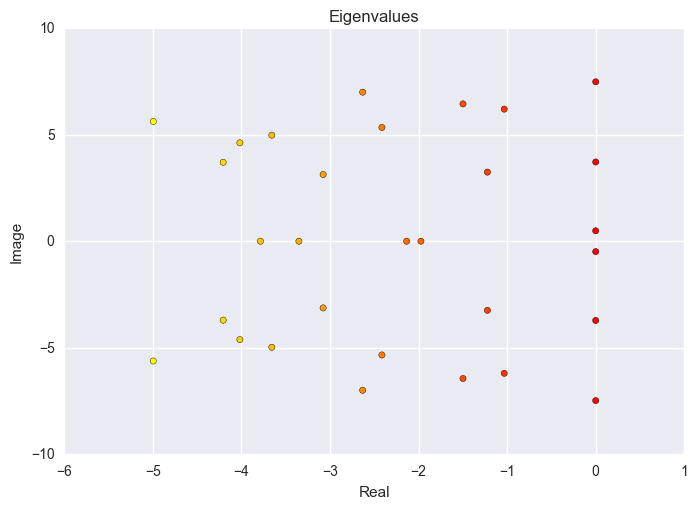

In [5]:
axes().set_ylabel('Image') 
axes().set_xlabel('Real')
title("Eigenvalues")
color = mean(impulse.eigenvalues.real) - impulse.eigenvalues.real
_ = scatter(impulse.eigenvalues.real, impulse.eigenvalues.imag, c=color, cmap='autumn')

# Постановка задачи

Задано $N=30$ исходных собственных чисел матрицы $A$. Требуется редуцировать порядок системы.
Если на вход системе подается испульсная дельта-функция Дирака $\delta(\theta - t_0)$, то получаем на выходе
$$y_k=\sum\limits_{p=1}^{P} \sum\limits_{j=1}^{n_p} \frac{(k \Delta)^{j-1}}{(j-1)!}(f_{p_j}^c \cos k \Delta \beta_p + f_{p_j}^s \sin k \Delta \beta_p) \exp(-\alpha_p k \Delta)$$


Задача – определить параметры редуцированной системы, а именно $f_q^c, f_q^s, \alpha_q, \beta_q$, когда
$$\tilde y_k = \sum\limits_{q=1}^Q (f_q^c \cos k \Delta \beta_q + f_q^s \sin k \Delta \beta_q) \exp(-\alpha_q k \Delta)$$

# Выполнение работы

In [6]:
def impulse_vec(x, params, delta=0.05):
    """
    Creates impulse reaction with given parameters and returns it.
    Assumes it's argument has `params = (f_c, f_s, alpha, beta)` structure.
    f_c = params[:q]
    f_s = params[q:2*q]
    alpha = params[2*q:3*q]
    beta = params[3*q:]
    """
    q = params.shape[0] // 4
    a_d = delta * params[2 * q:3 * q]
    a_d[a_d < 0] = 0 # heuristic
    b_d = delta * params[3 * q:]
    x_b = x[:, newaxis] * b_d
    coef = params[:q] * np.cos(x_b) + params[q:2*q] * np.sin(x_b)
    exp_val = np.exp(- x[:, newaxis] * a_d)
    return sum(multiply(coef, exp_val), axis=1)

In [7]:
def impulse_vec_grad(x, params, delta=0.05):
    """
    Creates impulse reaction with given parameters and returns it.
    Assumes it's argument has `params = [f_c, f_s, alpha, beta]` structure.
    f_c = params[:q]
    f_s = params[q:2*q]
    alpha = params[2*q:3*q]
    beta = params[3*q:]
    """
    q = params.shape[0] // 4
    f_c, f_s, alpha, beta = [row[:, newaxis] for row in params.reshape((4, q))]
    alpha[alpha < 0] = 0 # heuristic
    x_scaled = x * delta
    x_b = beta * x_scaled
    exp_val = np.exp(- alpha * x_scaled)
    dfc = exp_val * cos(x_b)
    dfs = exp_val * sin(x_b)
    exp_coef = f_c * np.cos(x_b) + f_s * np.sin(x_b)
    da = - exp_coef * exp_val * x_scaled
    db = exp_val * (f_s * np.cos(x_b) - f_c * np.sin(x_b)) * x_scaled
    return sum(exp_coef * exp_val, axis=0), vstack((dfc, dfs, da, db))

In [8]:
N = 500
support = arange(1,N + 1, 1)

In [9]:
noisy = impulse(support)

In [10]:
def cost_inf(vec):
    approx = impulse_vec(support, vec, impulse.delta)
    return max(abs(noisy - approx))

In [11]:
max_tol = 1e-4
size_x = support.shape[0]
def cost_grad_inf(vec):
    approx, grad = impulse_vec_grad(support, vec, impulse.delta)
    resid = approx - noisy
    result = max(abs(resid))
    sufficient = result - abs(resid) < max_tol
    return result, sum(sign(resid) * sufficient * grad / sum(sufficient), axis=1)

In [12]:
def starting_points():
    return itertools.product([-1, 1], [-1, 1], arange(0, 6, 1), arange(-10, 11, 1))

In [13]:
def generate_bounds(q):
    return [(None, None), (None, None), (0, 6), (-10, 10)] * q

In [18]:
def perform_inf_approximation(max_q, points_generator, max_rand_iter = 500):
    general_solution = None
    start_point = None
    start_default = array([[1], [1], [0], [0]], dtype=float64)
    fig, ax = subplots(max_q, 3, figsize=(15, 3*max_q))
    for q in range(max_q):
        current_solution = general_solution
        print("Current Q: %d" % (q + 1))
        axes = ax[q]
        axes[0].set_title(r"$y$ vs $\tilde{y}$")
        axes[1].set_title(r"$|y - \tilde{y}|$")
        axes[2].set_title(r"Eigenvalues")
        axes[2].set_xlabel('Real')
        axes[2].set_ylabel('Imag')
        axes[2].scatter(impulse.eigenvalues.real, impulse.eigenvalues.imag, marker='+')
        if current_solution is None:
            start_point = start_default
        else:
            start_point = np.hstack((current_solution.x.reshape((4, q)), start_default))
        bounds = generate_bounds(q + 1)
        for appendix in points_generator():
            start_point[:, -1] = appendix
            result = optimize.minimize(cost_grad_inf, start_point.ravel(), jac=True, bounds=bounds, method='SLSQP')
            if current_solution is None or current_solution.fun > result.fun:
                current_solution = result
                print("Updated result: {0}".format(result.fun))
        if current_solution.x.shape[0] <= q * 4 or general_solution is not None and \
        general_solution.fun < current_solution.fun * enhance_tol: # no enhancement
            print("Randomized search initiated")
            counter = 0
            while True:
                counter += 1
                if counter > max_rand_iter * (q + 1):
                    return
                start_point[:, -1] = [*random.choice([-1, 1], 2), 0, random.uniform(-10, 10)]
                result = optimize.minimize(cost_grad_inf, start_point.ravel(), jac=True, bounds=bounds, method='SLSQP')
                if current_solution.fun > result.fun * enhance_tol:
                    current_solution = result
                    print("Updated result: {0}".format(result.fun))
                    break
        #current_solution.x[2*(q+1):3*(q+1)][current_solution.x[2*q:3*q] < 0] = 0
        approx = impulse_vec(support, current_solution.x, impulse.delta)
        axes[0].plot(support, noisy, label="$y$")
        axes[0].plot(support, approx, label=r"$\tilde{y}$", c='red')
        axes[0].legend(loc='upper left')
        axes[1].plot(support, abs(noisy - approx))
        axes[1].axhline(current_solution.fun, c='red')
        axes[1].annotate("y = %.3f" % current_solution.fun, xy=(10, current_solution.fun*1.01), fontsize=9)
        *_, alpha, beta = current_solution.x.reshape((4, q + 1))
        axes[2].scatter(-alpha, beta, marker='x', c='red')
        yield current_solution
        general_solution = current_solution
    fig.tight_layout()

In [19]:
enhance_tol = 1.05

In [20]:
from IPython.display import clear_output
solutions = []
def runner(max_q, iter_count):
    global solution
    while True:
        solutions = list(perform_inf_approximation(max_q, starting_points, iter_count))
        if len(solutions) == max_q:
            return solutions
        iter_count += 100
        clear_output()
        print("Starting new loop...")
        print("Max iter: %d" % iter_count)

Current Q: 1
Updated result: 5.945975150173519
Updated result: 5.771238776452705


c:\users\vladf\appdata\local\programs\python\python35-32\lib\site-packages\scipy\optimize\slsqp.py:341: RuntimeWarning: invalid value encountered in greater
  bnderr = where(bnds[:, 0] > bnds[:, 1])[0]


Updated result: 5.589970789359061
Updated result: 5.404786691635199
Updated result: 4.841128226501289
Updated result: 4.478071460444658
Updated result: 4.473817194929938
Current Q: 2
Randomized search initiated
Updated result: 4.060824907191915
Current Q: 3
Updated result: 4.042493219154116
Randomized search initiated
Updated result: 3.1660478337095794
Current Q: 4
Updated result: 3.097060354717922
Updated result: 3.097060341518292
Randomized search initiated
Updated result: 2.720808720999748
Current Q: 5
Updated result: 2.681307395359348
Randomized search initiated
Updated result: 2.4496643606052104
Current Q: 6
Updated result: 1.8862519264855382
Updated result: 1.8773109480542738
Updated result: 1.8712768896936254
Updated result: 1.8617207145521097
Current Q: 7
Updated result: 1.8616610368244242
Randomized search initiated
Updated result: 1.5228025865965806
Current Q: 8
Updated result: 1.299825625496049
Updated result: 1.279691575867258
Current Q: 9
Updated result: 0.8502130499828784

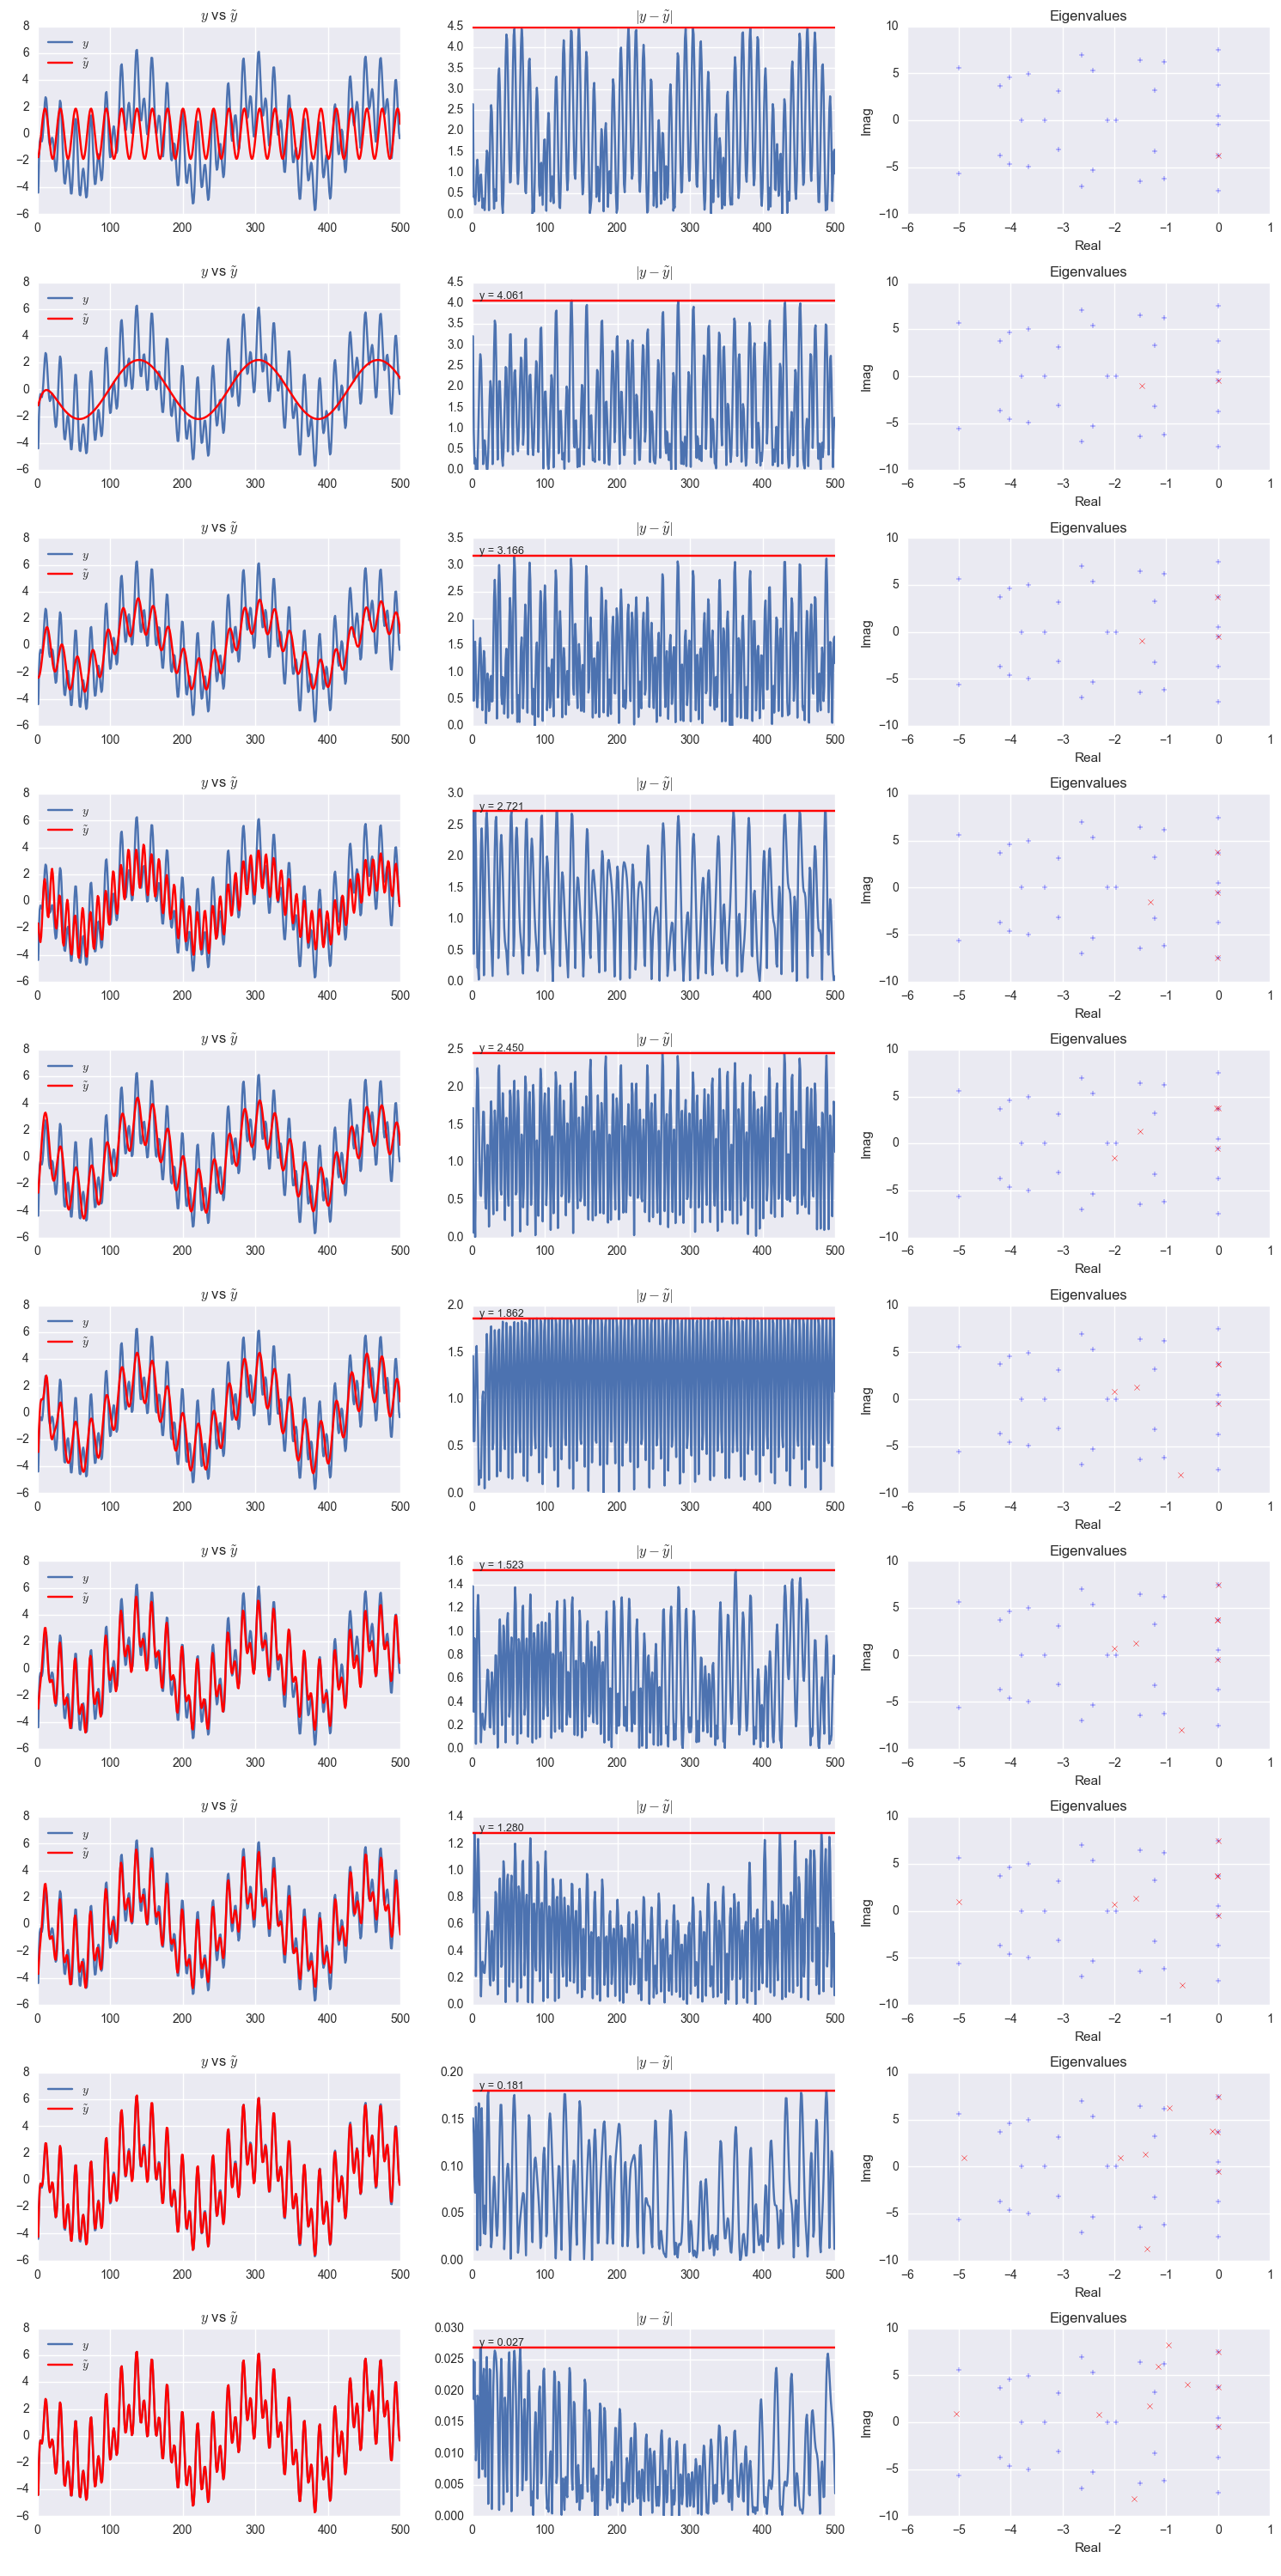

In [21]:
res = runner(10, 1500)
savez("result.npz", result=res)

#### Ideas how to improve:
- parallel calculation of the best solution using splitted grid set and worker pool
- increase bruteforce window (e.g. fix q - 2 parameters and change 2)
- adjust bruteforce grid

In [23]:
sol = res[-1]

In [28]:
for q in range(10):
    if any(res[q].x[2*(q+1):3*(q+1)] < 0):
        print(q, res[q].x[2*(q+1):3*(q+1)])

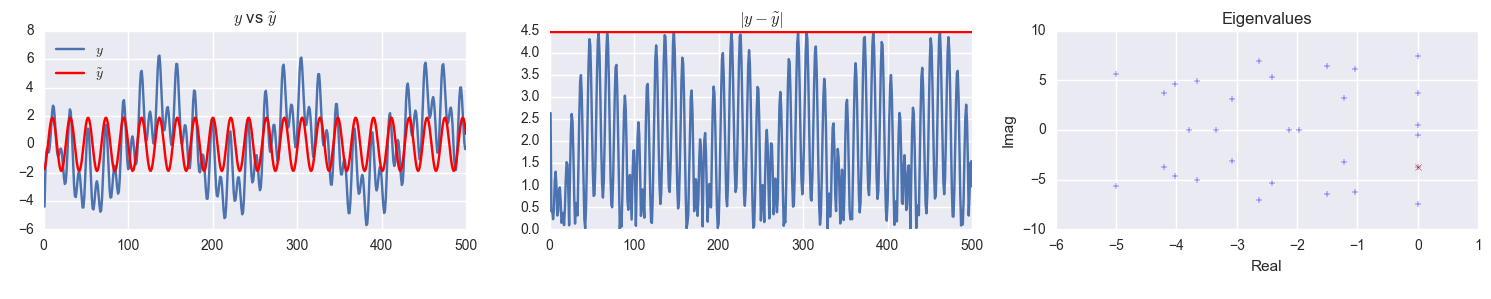

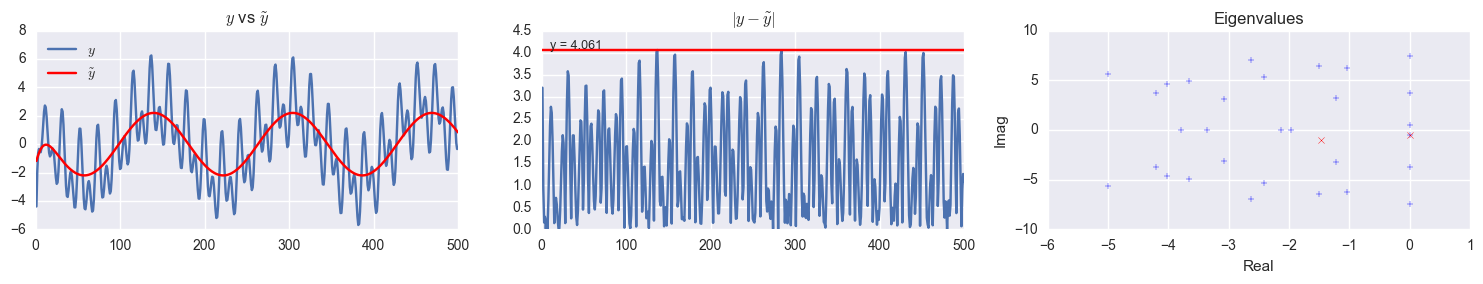

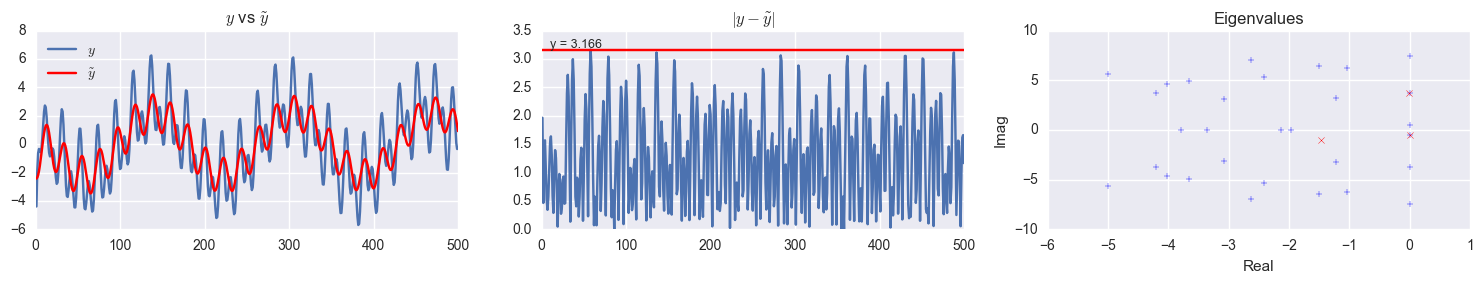

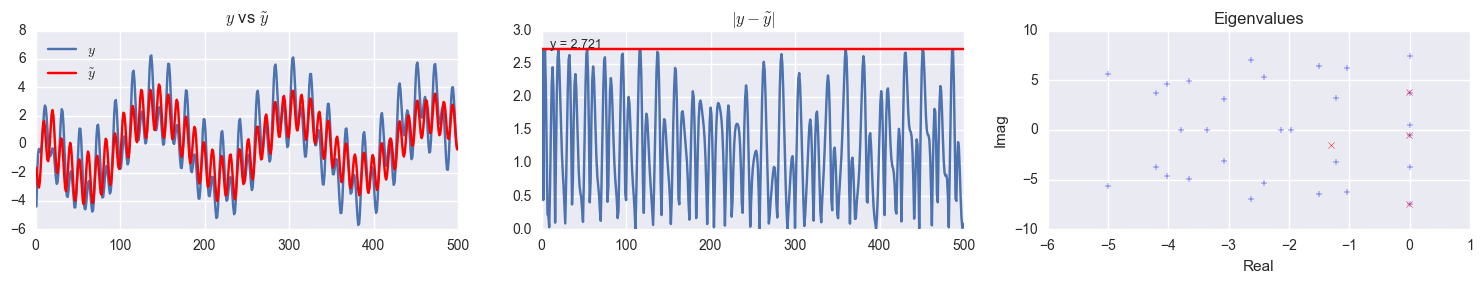

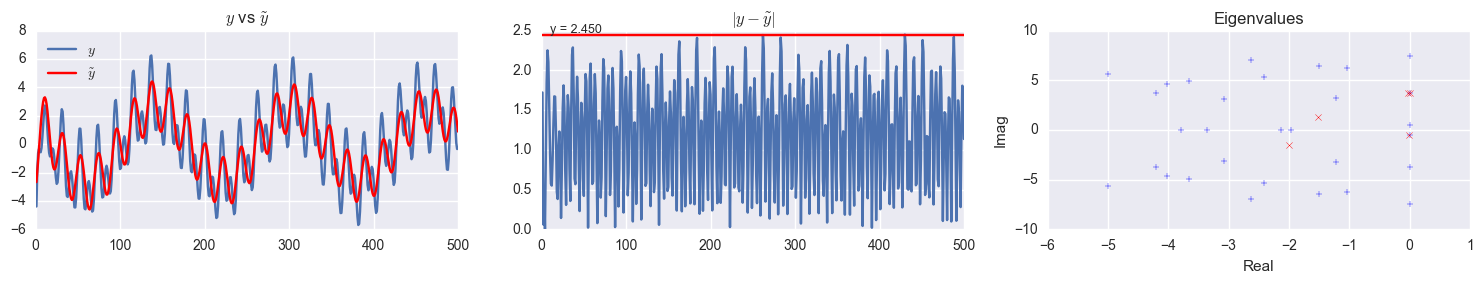

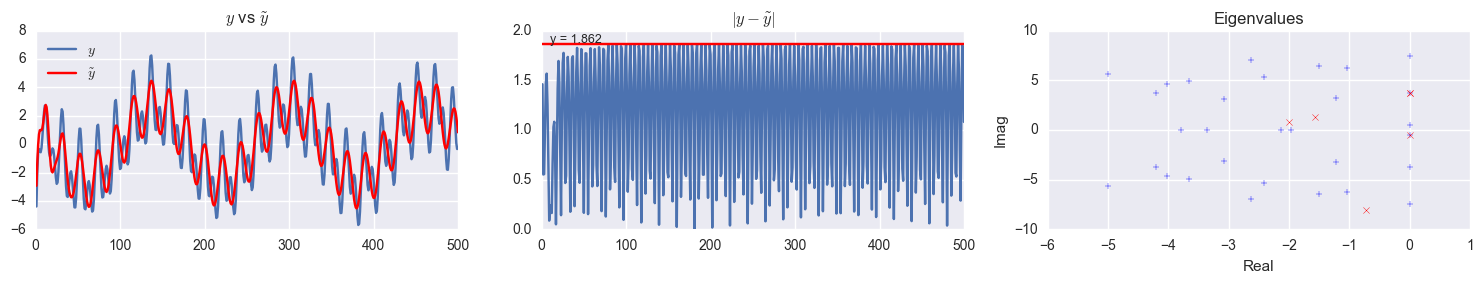

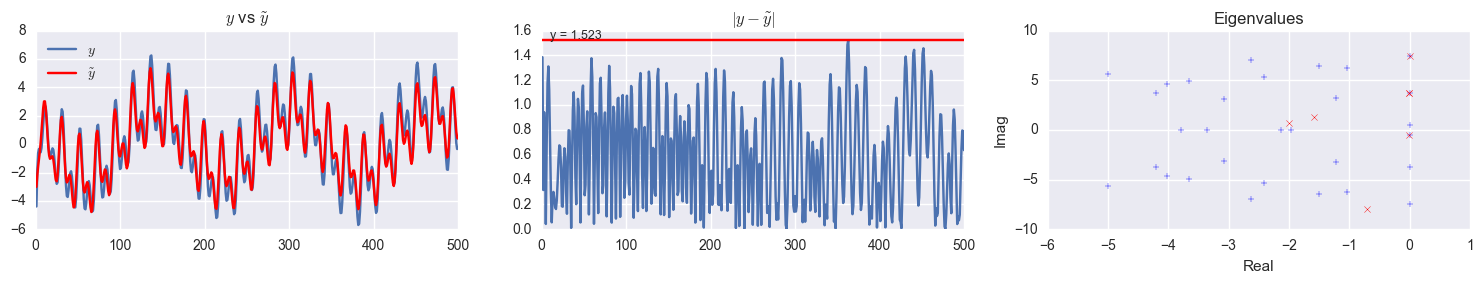

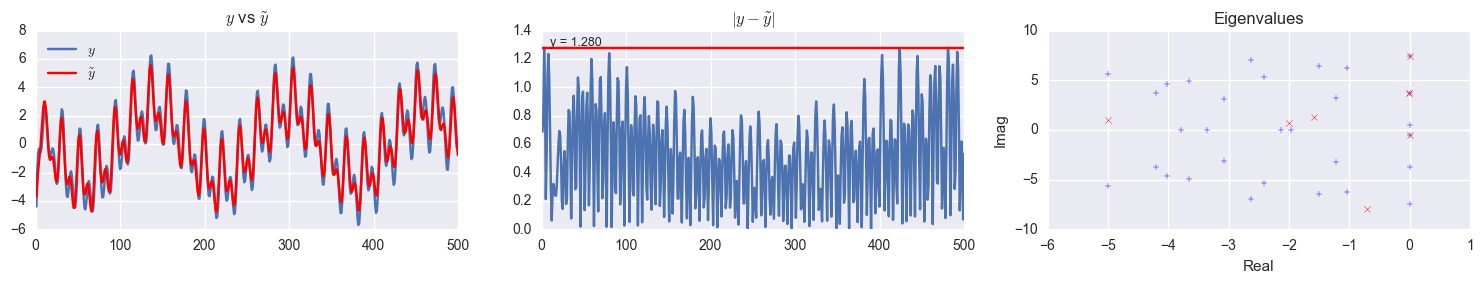

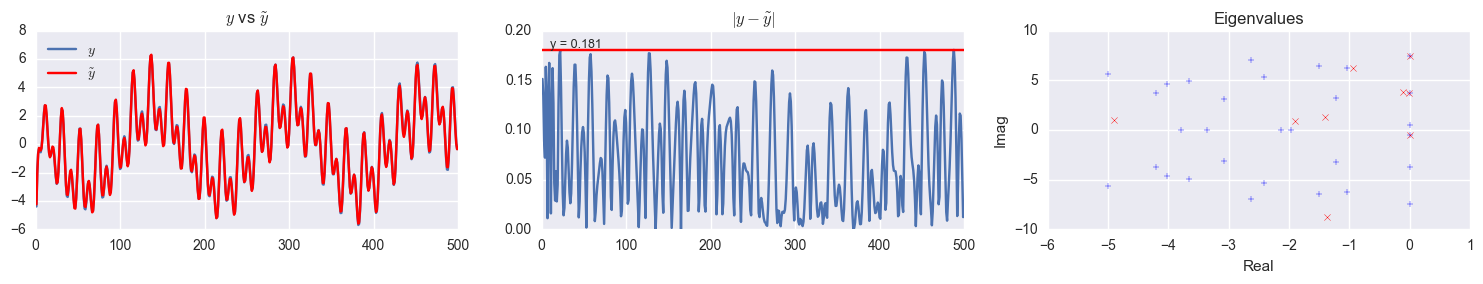

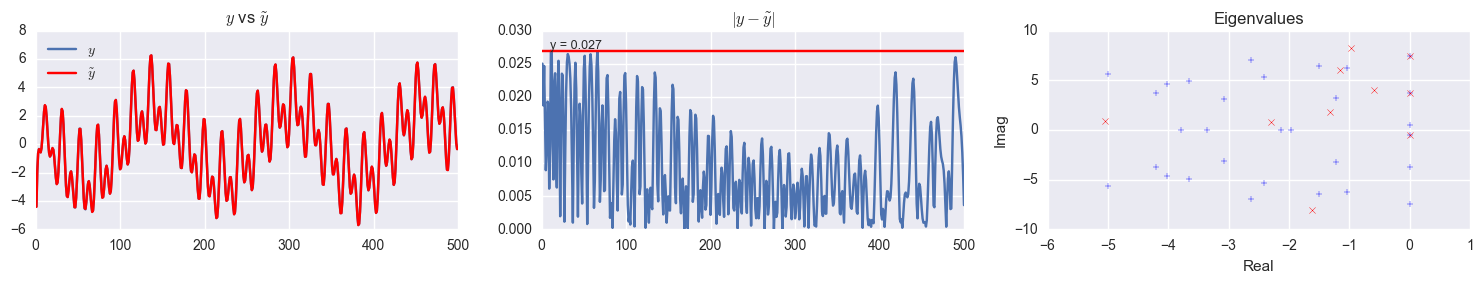

In [31]:
for q, solution in enumerate(res):
    fig, axes = subplots(1, 3, figsize=(15, 3))
    axes[0].set_title(r"$y$ vs $\tilde{y}$")
    axes[1].set_title(r"$|y - \tilde{y}|$")
    axes[2].set_title(r"Eigenvalues")
    axes[2].set_xlabel('Real')
    axes[2].set_ylabel('Imag')
    axes[2].scatter(impulse.eigenvalues.real, impulse.eigenvalues.imag, marker='+')
    approx = impulse_vec(support, solution.x, impulse.delta)
    axes[0].plot(support, noisy, label="$y$")
    axes[0].plot(support, approx, label=r"$\tilde{y}$", c='red')
    axes[0].legend(loc='upper left')
    axes[1].plot(support, abs(noisy - approx))
    axes[1].axhline(solution.fun, c='red')
    axes[1].annotate("y = %.3f" % solution.fun, xy=(10, solution.fun*1.01), fontsize=9)
    *_, alpha, beta = solution.x.reshape((4, q + 1))
    axes[2].scatter(-alpha, beta, marker='x', c='red')
    fig.tight_layout()
    fig.savefig("plot_%d" % (q+1), dpi=300)

In [34]:
%mkdir lab1_out
savez("lab1_out/result.npz", result=res)